# Uncertainty-Aware Deep Language Learning with BERT-SNGP

**Learning Objectives**:

* Learn how to build a [BERT](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2) model for text classification
* Learn how to augment the BERT classifier with a Spectral Normalized Gaussian Process (SNGP) to improve the uncertainty quality
* Learn how to load the [CLINC Out-of-scope (OOS)](https://www.tensorflow.org/datasets/catalog/clinc_oos) intent detection dataset and train BERT-SNGP on this dataset
* Evaluate the BERT-SNGP model's performance in uncertainty calibration and out-of-domain detection.

In this notebook, you will apply SNGP to a natural language understanding (NLU) task by building it on top of a deep BERT encoder to improve deep NLU model's ability in detecting out-of-scope queries. 
For the purpose of notebook,  we will use [CLINC Out-of-scope (OOS)](https://www.tensorflow.org/datasets/catalog/clinc_oos) intent detection dataset. However, the SNGP model has been applied to large-scale datasets such as [Jigsaw toxicity detection](https://www.tensorflow.org/datasets/catalog/wikipedia_toxicity_subtypes), and to the image datasets such as [CIFAR-100](https://www.tensorflow.org/datasets/catalog/cifar100) and [ImageNet](https://www.tensorflow.org/datasets/catalog/imagenet2012). 
For benchmark results of SNGP and other uncertainty methods, as well as high-quality implementation with end-to-end training / evaluation scripts, you can check out the [Uncertainty Baselines](https://github.com/google/uncertainty-baselines) benchmark.

**Acknowledgement:** This notebook is based on the the [TensorFlow tutorial](https://www.tensorflow.org/text/tutorials/uncertainty_quantification_with_sngp_bert) written by Jeremiah Liu.

## Setup

In [1]:
pip freeze | grep tf-models-official || pip install tf-models-official==2.8.0

tf-models-official==2.8.0
Note: you may need to restart the kernel to use updated packages.


In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.calibration
import sklearn.metrics
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from official.nlp.modeling.layers import (
    ClassificationHead,
    GaussianProcessClassificationHead,
)
from official.nlp.optimization import AdamWeightDecay

This tutorial needs a GPU to run efficiently. Let us check that GPUs are available:

In [93]:
gpus = tf.config.list_physical_devices("GPU")
assert gpus, "No GPU(s) found!"
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Implementing a classification BERT model 

First, we will implement a standard BERT classifier using the Keras model API (see our [classify text with BERT](notebooks/text_models/solutions/classify_text_with_bert.ipynb) tutorial for more details on the BERT model). We will use the [BERT-base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) encoder, and the built-in [`ClassificationHead`](https://github.com/tensorflow/models/blob/master/official/nlp/modeling/layers/cls_head.py) layer from [TF model garden](https://github.com/tensorflow/models/tree/master/official) as the classifier.

Recall that a BERT classifier consists essentially in 3 stages:

* A pre-processing stage where the sentences are broken up into [WordPiece](https://paperswithcode.com/method/wordpiece) tokens and the tokens mapped to integer ID's. This stage is implemented by a pre-processing layer that has no learnable weights.
* A encoding stage where the ID's representing the sentence tokens are transformed into BERT contextual vectors. This stage is usually implemented by a pre-trained layer that can be fine-tuned or frozen.
* A classification head that performs the actual classification based on the contextual vectors preduced by the BERT encoder. This stage is implemented by layers that have learnable weights. 

In our version, the first two stages will be implemented by [TF-Hub modules](https://tfhub.dev/), with a [english uncased pre-processor module](https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3) followed by a corresponding [BERT encoder](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) producing contextual vectors of dimension 768. The class `KerasLayer` will allow us to import these modules as standard Keras layers from their TF-Hub URLs.


[TensorFlow model garden](https://www.tensorflow.org/tfmodels) provides a simple `ClassificationHead` layer that can be composed directly to the output of a BERT encoder. (More precisely, a BERT encoder returns a dictonary containing the contextual vectors for each token along with a single vector of the same dimension representing the whole sentence; this is the vector that will be passed to the `ClassificationHead` layer and it is retrieved as the `encoder_outputs["sequence_output"]` value from the encoder output-dictionary.) This layer is imported by the following statement:

```python
from official.nlp.modeling.layers import ClassificationHead
```
It has 3 main arguments
```python
ClassificationHead(num_classes, inner_dim, dropout_rate)
```
where `num_classes` is the number of classes for the downstream classification task, `inner_dim` is the BERT-encoder contextual-vector dimension (here 768), and `dropout_rate` is the dropout regularization rate to be applied. 

We will implement the BERT classifier following a similar strategy to the one we used in the [SNGP lab for the two-moon dataset](https://github.com/GoogleCloudPlatform/asl-ml-immersion/blob/master/notebooks/uncertainty_aware_models/solutions/uncertainty_awareness_in_deep_learning.ipynb), i.e., we will create a model class with two methods `make_bert_encoder` (first two stages) and `make_classification_head` (last stage) constructing the different stages of the BERT classifier. Then, we will implement SNGP on the top of our BERT classifier model by overriding the methods in a derived SNGP-BERT class. 

In [20]:
PREPROCESS_HANDLE = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
MODEL_HANDLE = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"


class BertClassifier(tf.keras.Model):
    def __init__(
        self,
        num_classes=150,
        inner_dim=768,
        dropout_rate=0.1,
        **classifier_kwargs,
    ):

        super().__init__()
        self.classifier_kwargs = classifier_kwargs

        # Initiate the BERT encoder components.
        self.bert_preprocessor = hub.KerasLayer(
            PREPROCESS_HANDLE, name="preprocessing"
        )
        self.bert_hidden_layer = hub.KerasLayer(
            MODEL_HANDLE, trainable=True, name="bert_encoder"
        )

        # Defines the encoder and classification layers.
        self.bert_encoder = self.make_bert_encoder()
        self.classifier = self.make_classification_head(
            num_classes, inner_dim, dropout_rate
        )

    def make_bert_encoder(self):
        text_inputs = tf.keras.layers.Input(
            shape=(), dtype=tf.string, name="text"
        )
        encoder_inputs = self.bert_preprocessor(text_inputs)
        encoder_outputs = self.bert_hidden_layer(encoder_inputs)
        return tf.keras.Model(text_inputs, encoder_outputs)

    def make_classification_head(self, num_classes, inner_dim, dropout_rate):
        return ClassificationHead(
            num_classes=num_classes,
            inner_dim=inner_dim,
            dropout_rate=dropout_rate,
            **self.classifier_kwargs,
        )

    def call(self, inputs, **kwargs):
        encoder_outputs = self.bert_encoder(inputs)
        classifier_inputs = encoder_outputs["sequence_output"]
        return self.classifier(classifier_inputs, **kwargs)

### Load CLINC OOS dataset

Now let us load the [CLINC OOS](https://www.tensorflow.org/datasets/catalog/clinc_oos) intent detection dataset. This dataset contains 15 000 user's spoken queries collected over 150 intent classes, it also contains 1000 out-of-domain (OOD) sentences that are not covered by any of the known classes. 

We will train our BERT classifier to recognize the possible 150 intents in the queries, and we will then evaluate how uncertain the classifier becomes when confronted to queries outside of the 150 intent scope. 

In [94]:
DATSET_NAME = "clinc_oos"

(clinc_train, clinc_test, clinc_test_oos), ds_info = tfds.load(
    DATSET_NAME,
    split=["train", "test", "test_oos"],
    with_info=True,
    batch_size=-1,
)

Let us now retrieve our train and test sets:

In [10]:
train_examples = clinc_train["text"]
train_labels = clinc_train["intent"]

# Makes the in-domain (IND) evaluation data.
ind_eval_data = (clinc_test["text"], clinc_test["intent"])

Let look at a query input to our model:

In [96]:
train_examples[0].numpy()

b'please inform me when my flight scheduled to board'

### Training BERT on CLINC dataset

To improve training in the case of BERT , we need to use a more sophisticated optimizer than just `Adam`. In the cell below we implement a function that return a version of the `Adam` optimizer but where the learning rate is scheduled to decay as the training progresses. We will need to first configure a learning rate schedule using one of the scheduled defined in `tf.keras.optimizers.schedules`. This schedule contains the information of the initial learning rate, the final learning rate, as well as the number of steps we want to decay the initial learning rate into the final learning rate. We will set this number of steps to be simply the total number of training steps. 

Once the schedule is configured, we can pass it to the `AdamWeightDecay` optimizer that we need to use for BERT. It is imported with the statement

```python
from official.nlp.optimization import AdamWeightDecay
```

The function below returns a configured instance of this optimizer:

In [28]:
def create_bert_optimizer(
    learning_rate,
    batch_size=TRAIN_BATCH_SIZE,
    epochs=TRAIN_EPOCHS,
):
    """Creates an AdamWeightDecay optimizer with learning rate schedule."""
    train_data_size = ds_info.splits["train"].num_examples

    steps_per_epoch = int(train_data_size / batch_size)
    num_train_steps = steps_per_epoch * epochs

    # Creates learning schedule.
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=num_train_steps,
        end_learning_rate=0.0,
    )

    return AdamWeightDecay(
        learning_rate=lr_schedule,
        weight_decay_rate=0.01,
        epsilon=1e-6,
        exclude_from_weight_decay=["LayerNorm", "layer_norm", "bias"],
    )

Let us now train our model:

In [30]:
TRAIN_EPOCHS = 3
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 256

optimizer = create_bert_optimizer(learning_rate=1e-4)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.SparseCategoricalAccuracy()

fit_configs = dict(
    batch_size=TRAIN_BATCH_SIZE,
    epochs=TRAIN_EPOCHS,
    validation_batch_size=EVAL_BATCH_SIZE,
    validation_data=ind_eval_data,
)

bert_model = BertClassifier()
bert_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
bert_model.fit(train_examples, train_labels, **fit_configs)

Epoch 1/3
469/469 [==============================] - 504s 1s/step - loss: 0.8576 - sparse_categorical_accuracy: 0.8313 - val_loss: 0.2550 - val_sparse_categorical_accuracy: 0.9396
Epoch 2/3
469/469 [==============================] - 492s 1s/step - loss: 0.0713 - sparse_categorical_accuracy: 0.9830 - val_loss: 0.1934 - val_sparse_categorical_accuracy: 0.9571
Epoch 3/3
469/469 [==============================] - 492s 1s/step - loss: 0.0191 - sparse_categorical_accuracy: 0.9954 - val_loss: 0.1639 - val_sparse_categorical_accuracy: 0.9651


### Creating the out-of-distribution dataset

The CLINC OOS dataset comes with an additional split "test_oos" that contains queries that are out of the scope defined by the original 150 intents in the training and test sets. (We stored that OOS split into the `clinc_test_oos` variable previously.) We want to use this OOS queries to evaluate how good our model is at recognizing when its input deviates significantly from the training distribution. 

For this, we combine the in-domain test data `clinc_test` and with out-of-domain test data `clinc_test_oos` into a single dataset, where we assign label 0 to the in-domain examples, and label 1 to the out-of-domain examples. Then we convert this dataset into a `tf.data.Dataset` using `tf.data.Dataset.from_tensor_slices`:


In [11]:
test_data_size = ds_info.splits["test"].num_examples
oos_data_size = ds_info.splits["test_oos"].num_examples

# Combines the in-domain and out-of-domain test examples.
oos_texts = tf.concat([clinc_test["text"], clinc_test_oos["text"]], axis=0)
oos_labels = tf.constant([0] * test_data_size + [1] * oos_data_size)

# Converts into a TF dataset.
ood_eval_dataset = tf.data.Dataset.from_tensor_slices(
    {"text": oos_texts, "label": oos_labels}
)

### Evaluating OOD performance

In general, the class detected by a classifier is the class for which the model outputs the highest probability. Ideally, we would like to interpret this probability as a measure of the confidence of the classifier in its predictions: The higher the probability is the more certain the classifier should be. For out-of-domain queries, or input points, we would then want the classifier to output a low probability for each of the class, with the limiting case being the uniform probability $p = 1/k$ for each of the $k$ classes, indicating that the classifier is clueless on that type of input. 

How can we measure if the classifier is good at recognizing OOD points? One way to do this is to look at the probability $p$ of the highest class and turn it into a detection score $1-p$. If the classifier is good at recognizing OOD point, then this score should be higher on OOD points than it is on points close to the data distribution. 

Following on this idea, we can then manufacture a labelled OOD dataset consisting of a first half with out-of-domain points labelled 1 and a second half with in-domain points labelled 0. The preformance of our original classifier at detecting OOD points can then be identified with the peformance of the binary OOD classifier given by the score $1-p$. To measure this performance without needing to chose a particular threshold we can use a metric like the Area Under the Curve. A random classifier would have an AUC of 0.5 and any AUC score higher is then better than random. 


The function below takes the classification mode and the OOD dataset as input, and it returns the highest probability $p(x)$ for each input $x$ along with the OOD labels:


In [32]:
def oos_predict(model, ood_eval_dataset, **model_kwargs):
    oos_labels = []
    oos_probs = []

    ood_eval_dataset = ood_eval_dataset.batch(EVAL_BATCH_SIZE)
    for oos_batch in ood_eval_dataset:
        oos_text_batch = oos_batch["text"]
        oos_label_batch = oos_batch["label"]

        pred_logits = model(oos_text_batch, **model_kwargs)
        pred_probs_all = tf.nn.softmax(pred_logits, axis=-1)
        pred_probs = tf.reduce_max(pred_probs_all, axis=-1)

        oos_labels.append(oos_label_batch)
        oos_probs.append(pred_probs)

    oos_probs = tf.concat(oos_probs, axis=0)
    oos_labels = tf.concat(oos_labels, axis=0)

    return oos_probs, oos_labels

Let us now compute the OOD probabilities $1 - p(x)$, where $p(x)=\max(\textrm{softmax}(\textrm{logit}(x)))$ is the predictive probability:

In [101]:
bert_probs, bert_ood_labels = oos_predict(bert_model, ood_eval_dataset)

In [89]:
bert_ood_probs = 1 - bert_probs

One way to evaluate how good the OOD probabilities are at separating the in-domain data points (true label = 0) from the out-of-domain data points (true label = 1) is to plot the distribution of the probabilities for both types of points. If the OOD probabilities are effective at classifying OOD points vs IND points, the probability values for the IND points should be concentrated around zero while for OOD point their values should be concentrated around 1, with a clear separation between the two modes. 

The function below takes as input the OOD probabilities as well as their true labels and plots the distribution histogram for both classes.

In [148]:
def visualize_ood_probs(ood_probs, ood_labels):
    fig, axs = plt.subplots(figsize=(25, 6), ncols=2, nrows=1)

    sns.histplot(
        ood_probs[ood_labels == 0], ax=axs[0], color="blue", kde=True
    ).set(
        xlim=[0, 1],
        ylim=[0, 10],
        title="Probability distribution for in-domain data",
    )

    sns.histplot(
        ood_probs[ood_labels == 1], ax=axs[1], color="red", kde=True
    ).set(xlim=[0, 1], title="Probability distribution for out-of-domain data")

As we see below, while a plain BERT models yields OOD probabilities that are concentrated around zero for the in-domain data points (in blue), the OOD probabilities for the out-of-domain points (in red) are all over the place with no clear separation from the in-domain probability values. This means that the model may have difficulties to clearly recognize that a input point is out-of-domain for certain types of OOD inputs. 

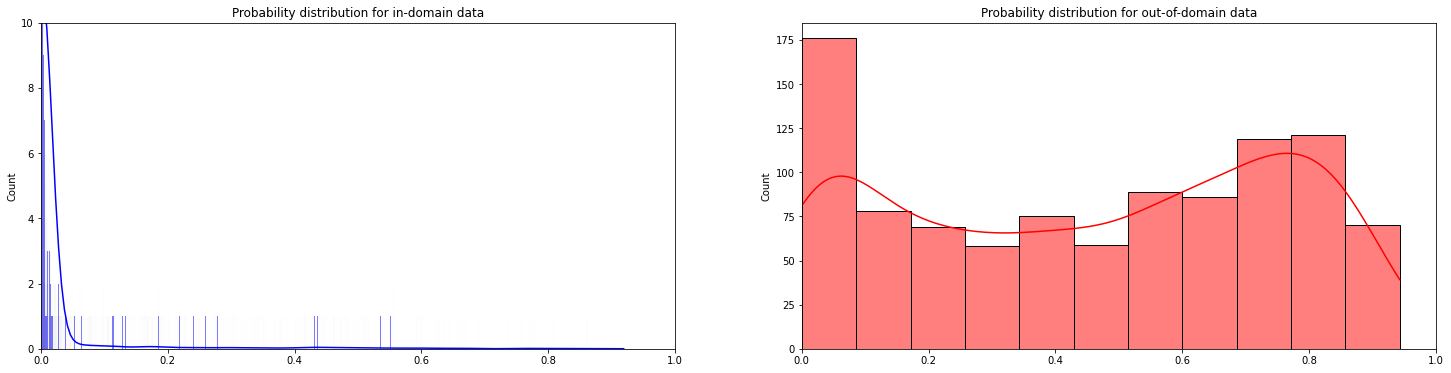

In [149]:
visualize_ood_probs(bert_ood_probs, bert_ood_labels)

Another way to evaluate how well the model OOD probabilities predicts the out-of-domain label, is to compute the [Area Under Precision-Recall curve (AUPRC)](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html) for the corresponding OOD classifier:

In [90]:
bert_precision, bert_recall, _ = sklearn.metrics.precision_recall_curve(
    ood_labels, bert_ood_probs
)

In [91]:
bert_auprc = sklearn.metrics.auc(bert_recall, bert_precision)
print(f"BERT AUPRC: {auprc:.4f}")

BERT AUPRC: 0.8896


The score is much higher than 0.5, which means that our BERT classifier is better than random at detecting wether a data point is far away from the training distribution. 

### Evaluating model calibration

Next, examine the model's quality in [uncertainty calibration](https://scikit-learn.org/stable/modules/calibration.html), i.e., whether the model's predictive probability corresponds to its predictive accuracy. A well-calibrated model is considered trust-worthy, since, for example, its predictive probability $p(x)=0.8$ means that the model is correct 80% of the time.

To evaluate a classifier calibration we can plot the fraction of time the classifier is correct when it predicts a probability $p$ (predictive accuracy) against the classifier output probability $p$ itself (predictive probability). This curve is callled the *calibration curve*. A well-calibrated model displays a calibration curve that matches the identity line with predictive accuracy matching predictive probabilities.

[scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html) provides functions to compute and plot the calibration curve:

In [39]:
prob_true, prob_pred = sklearn.calibration.calibration_curve(
    ood_labels, bert_ood_probs, n_bins=10, strategy="quantile"
)

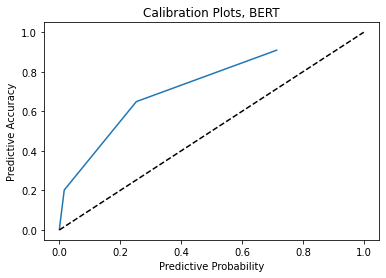

In [97]:
plt.plot(prob_pred, prob_true)

plt.plot([0.0, 1.0], [0.0, 1.0], c="k", linestyle="--")
plt.xlabel("Predictive Probability")
plt.ylabel("Predictive Accuracy")
plt.title("Calibration Plots, BERT")

plt.show()

From the calibration curve above, we see that our BERT model is not well-calibrated since it generally outputs probabilities that are  lower than the actual predictive accurracies. 

We now show how to apply SNGP (which we cover in the [SNGP lab](https://github.com/GoogleCloudPlatform/asl-ml-immersion/blob/master/notebooks/uncertainty_aware_models/solutions/uncertainty_awareness_in_deep_learning.ipynb)) to our BERT mode.

We will see that SNGP will both increase the OOD detection power (AUPRC) as well as the model calibration.

### Build SNGP model

To implement a BERT-SNGP model, you only need to replace the `ClassificationHead` with the built-in [`GaussianProcessClassificationHead`](https://github.com/tensorflow/models/blob/master/official/nlp/modeling/layers/cls_head.py).  This layer is part of the [TF Model Garden library](https://www.tensorflow.org/tfmodels) and can be imported with the statement:

```python
from official.nlp.modeling.layers import GaussianProcessClassificationHead
```


Like in the [SNGP lab](https://github.com/GoogleCloudPlatform/asl-ml-immersion/blob/master/notebooks/uncertainty_aware_models/solutions/uncertainty_awareness_in_deep_learning.ipynb), we have to add a covariance reset callback to the model, so the model automatically reset the covariance estimator at the begining of a new epoch to avoid counting the same data twice. Let us implement this callback by sub-classing from `tf.keras.callbacks.Callback`: 

In [69]:
class ResetCovarianceCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        """Resets covariance matrix at the begining of the epoch."""
        if epoch > 0:
            self.model.classifier.reset_covariance_matrix()

Now we derive `SNGPBertClassifier` from our base class `BertClassifier` and override the `make_classification_head` so that it uses a `GaussianProcessClassificationHead` instead of the standard `ClassificationHead`. Spectral normalization is already pre-packaged into this classification head so we won't need to override any other method. Thos layer will scale the BERT classifier logits with

$$\frac{\textrm{logit}(x)}{\sqrt{1+ \lambda * \sigma^2(x)}}$$

where $\sigma^2(x)$ is the SNGP variance, and $\lambda$ is an hyper-parameter (often chosen as $\pi/8$ or $3/\pi^2$).

The `GaussianProcessClassificationHead` takes a new argument `temperature`, which corresponds to the hyper-paramter $\lambda$ (see  [SNGP lab](https://github.com/GoogleCloudPlatform/asl-ml-immersion/blob/master/notebooks/uncertainty_aware_models/solutions/uncertainty_awareness_in_deep_learning.ipynb) for a detailed description). In practice, this value is usually treated as a hyperparameter, and is fine-tuned to optimize the model's calibration performance.

The `SNGPBertClassifier` also overrides the `fit` method so that it always add `ResetCovarianceCallback` to the list of callbacks using the same strategy as in [SNGP lab](https://github.com/GoogleCloudPlatform/asl-ml-immersion/blob/master/notebooks/uncertainty_aware_models/solutions/uncertainty_awareness_in_deep_learning.ipynb):

In [70]:
class SNGPBertClassifier(BertClassifier):
    def make_classification_head(self, num_classes, inner_dim, dropout_rate):
        return layers.GaussianProcessClassificationHead(
            num_classes=num_classes,
            inner_dim=inner_dim,
            dropout_rate=dropout_rate,
            temperature=30.0,
            **self.classifier_kwargs,
        )

    def fit(self, *args, **kwargs):
        """Adds ResetCovarianceCallback to model callbacks."""
        kwargs["callbacks"] = list(kwargs.get("callbacks", []))
        kwargs["callbacks"].append(ResetCovarianceCallback())

        return super().fit(*args, **kwargs)

We can now train our SNGP-BERT model in the very same way we trained the original model:

In [71]:
optimizer = create_bert_optimizer(learning_rate=1e-4)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.SparseCategoricalAccuracy()

fit_configs = dict(
    batch_size=TRAIN_BATCH_SIZE,
    epochs=TRAIN_EPOCHS,
    validation_batch_size=EVAL_BATCH_SIZE,
    validation_data=ind_eval_data,
)

sngp_model = SNGPBertClassifier()
sngp_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
sngp_model.fit(train_examples, train_labels, **fit_configs)

Epoch 1/3
469/469 [==============================] - 509s 1s/step - loss: 1.0535 - sparse_categorical_accuracy: 0.7902 - val_loss: 0.3708 - val_sparse_categorical_accuracy: 0.9424
Epoch 2/3
469/469 [==============================] - 495s 1s/step - loss: 0.0932 - sparse_categorical_accuracy: 0.9783 - val_loss: 0.2137 - val_sparse_categorical_accuracy: 0.9602
Epoch 3/3
469/469 [==============================] - 494s 1s/step - loss: 0.0230 - sparse_categorical_accuracy: 0.9953 - val_loss: 0.1835 - val_sparse_categorical_accuracy: 0.9658


Let us evaluate the uncertainty quality of this new model.

First we visualize the value distributions for the OOD probabilities:

In [116]:
sngp_probs, sngp_ood_labels = oos_predict(sngp_model, ood_eval_dataset)

In [ ]:
sngp_ood_probs = 1 - sngp_probs

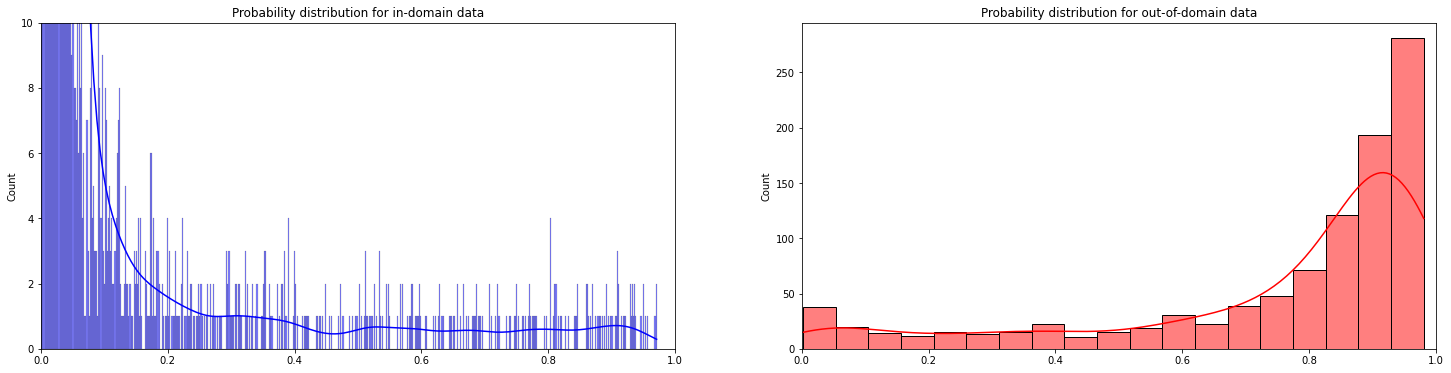

In [150]:
visualize_ood_probs(sngp_ood_probs, sngp_ood_labels)

We see that now the OOD points are well separated from the IND points with a clear concentration around 0 for the IND points and around 1 for the OOD points. Because of that we should expect an higher AUPRC for the associated OOD classifier:

In [82]:
sngp_precision, sngp_recall, _ = sklearn.metrics.precision_recall_curve(
    ood_labels, sngp_ood_probs
)

In [83]:
auprc = sklearn.metrics.auc(sngp_recall, sngp_precision)
print(f"SNGP AUPRC: {auprc:.4f}")

SNGP AUPRC: 0.8896


We see that the performance improved from the original BERT!

Let us now plot the calibration curve:

In [84]:
sngp_prob_true, sngp_prob_pred = sklearn.calibration.calibration_curve(
    ood_labels, sngp_ood_probs, n_bins=10, strategy="quantile"
)

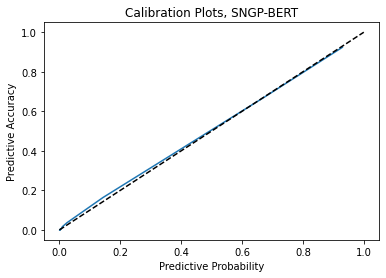

In [98]:
plt.plot(sngp_prob_pred, sngp_prob_true)

plt.plot([0.0, 1.0], [0.0, 1.0], c="k", linestyle="--")
plt.xlabel("Predictive Probability")
plt.ylabel("Predictive Accuracy")
plt.title("Calibration Plots, SNGP-BERT")

plt.show()

Now we see this is a striking improvement from the model without SNGP. The calibration curve is almost exactly coinciding with the identity line, which means that we can trust our model when it says it is confident with 80% since the predictive probabilities are almost the same as the predictive accuraries.

This is a significant improvement from the original model!


## Resources and further reading

* See the [SNGP lab](https://github.com/GoogleCloudPlatform/asl-ml-immersion/blob/master/notebooks/uncertainty_aware_models/solutions/uncertainty_awareness_in_deep_learning.ipynb) for an detailed walkthrough of implementing SNGP from scratch. 
* See [Uncertainty Baselines](https://github.com/google/uncertainty-baselines)  for the implementation of SNGP model (and many other uncertainty methods) on a wide variety of benchmark datasets (e.g., [CIFAR](https://www.tensorflow.org/datasets/catalog/cifar100), [ImageNet](https://www.tensorflow.org/datasets/catalog/imagenet2012), [Jigsaw toxicity detection](https://www.tensorflow.org/datasets/catalog/wikipedia_toxicity_subtypes), etc).
* For a deeper understanding of the SNGP method, check out the paper [Simple and Principled Uncertainty Estimation with Deterministic Deep Learning via Distance Awareness](https://arxiv.org/abs/2006.10108).


Copyright 2022 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.